# Reverse Image Search System By Fine-tuning VGG16

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/data-IM/Splited.zip'
extract_dir = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete")


Extraction complete


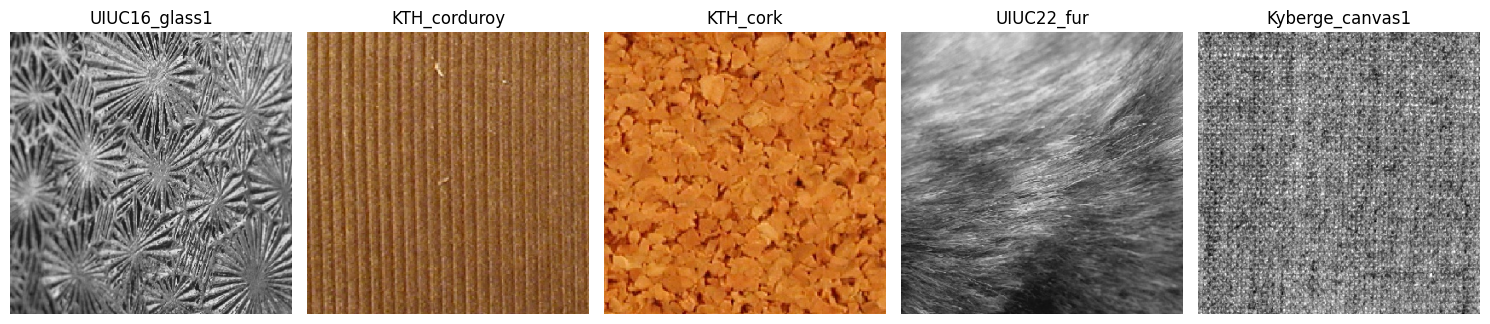

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image

dataset_directory = '/content/train'

num_classes = 0

plt.figure(figsize=(15, 10))

for class_name in os.listdir(dataset_directory):
    class_dir = os.path.join(dataset_directory, class_name)

    if os.path.isdir(class_dir):
        image_name = os.listdir(class_dir)[0]
        image_path = os.path.join(class_dir, image_name)

        image = Image.open(image_path)

        num_classes += 1

        plt.subplot(2, 5, num_classes)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')

        if num_classes == 5:
            break

plt.tight_layout()
plt.show()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout, MaxPooling2D
from keras import Sequential
from keras.callbacks import EarlyStopping

# Data Augumentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)


valid_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = valid_datagen.flow_from_directory(
    '/content/valid',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)


Found 4335 images belonging to 64 classes.
Found 4340 images belonging to 64 classes.


In [6]:
# # Generators

# train_ds = keras.utils.image_dataset_from_directory(
#     directory='/content/train',
#     labels='inferred',
#     label_mode='int',
#     batch_size=16,
#     image_size=(256,256)
# )

# val_ds = keras.utils.image_dataset_from_directory(
#     directory='/content/valid',
#     labels='inferred',
#     label_mode='int',
#     batch_size=16,
#     image_size=(256,256)
# )

In [7]:
# # Normalise

# def preprocess(image, label):
#   image = tf.cast(image/255., tf.float32)
#   return image, label

# train_ds = train_ds.map(preprocess)
# val_ds = val_ds.map(preprocess)

# Custom CNN Arch

In [23]:
# Custom - CNN
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=(150,150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='softmax'))

In [24]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 75, 75, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 75, 75, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 19, 19, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 19, 19, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 5, 5, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,976 (511.62 KB)

 Trainable params: 130,752 (510.75 KB)

 Non-trainable params: 224 (896.00 B)

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
earlyStopping = EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=1
)

In [27]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
)

Epoch 1/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 50s 154ms/step - accuracy: 0.1895 - loss: 3.3503 - val_accuracy: 0.0733 - val_loss: 5.5384
Epoch 2/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 39s 143ms/step - accuracy: 0.3621 - loss: 2.1992 - val_accuracy: 0.4336 - val_loss: 1.9600
Epoch 3/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 39s 146ms/step - accuracy: 0.4490 - loss: 1.8211 - val_accuracy: 0.4251 - val_loss: 1.9700
Epoch 4/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 38s 139ms/step - accuracy: 0.5133 - loss: 1.5943 - val_accuracy: 0.3659 - val_loss: 3.1780
Epoch 5/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 35s 128ms/step - accuracy: 0.5729 - loss: 1.3245 - val_accuracy: 0.4258 - val_loss: 2.1836


 ### Since custom CNN is not able to perform well, we will use VGG-16 model, which has 16 layers and fine-tune it

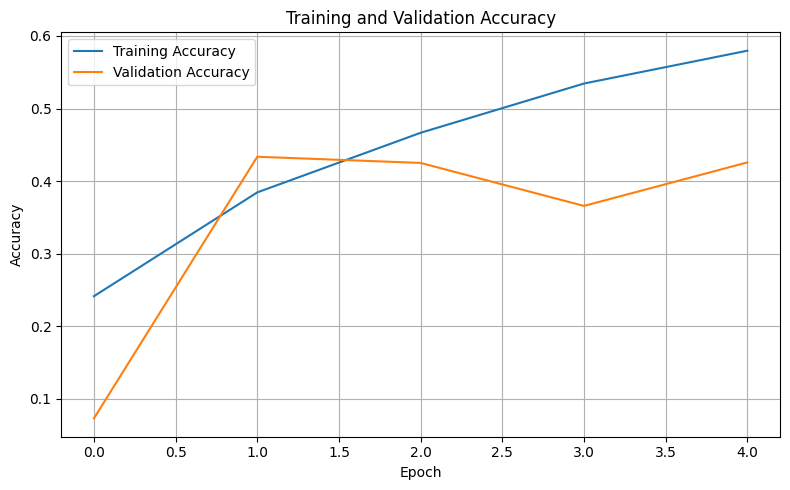

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Fine-Tuning using VGG-16 is a better approach since we have limited data

In [29]:
from keras.applications.vgg16 import VGG16

In [30]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# MAking the last conv-layer trainable

In [31]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name, layer.trainable)

input_layer_4 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


# CNN -VGG16 + our Dense Layers

In [42]:
model = Sequential()

model.add(conv_base)

model.add(Flatten())

model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(64, activation='softmax'))

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)


valid_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = valid_datagen.flow_from_directory(
    '/content/valid',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)


Found 4335 images belonging to 64 classes.
Found 4340 images belonging to 64 classes.


In [44]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

adam = Adam(learning_rate = 0.0001) # Low Learning rate recommended while using predefined weights

In [45]:
earlyStopping = EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=1
)

save_path = '/content/drive/MyDrive/textures_model_checkpoint.keras'

checkpoint = ModelCheckpoint(
    filepath=save_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [46]:
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,853,248 (64.29 MB)

 Trainable params: 9,217,984 (35.16 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [49]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[earlyStopping, checkpoint]
)

Epoch 1/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4742 - loss: 2.2888
Epoch 1: val_loss improved from inf to 0.52507, saving model to /content/drive/MyDrive/textures_model_checkpoint.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 88s 216ms/step - accuracy: 0.4749 - loss: 2.2855 - val_accuracy: 0.8553 - val_loss: 0.5251
Epoch 2/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8498 - loss: 0.5072
Epoch 2: val_loss improved from 0.52507 to 0.25157, saving model to /content/drive/MyDrive/textures_model_checkpoint.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 72s 183ms/step - accuracy: 0.8499 - loss: 0.5070 - val_accuracy: 0.9226 - val_loss: 0.2516
Epoch 3/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9231 - loss: 0.2477
Epoch 3: val_loss improved from 0.25157 to 0.22658, saving model to /content/drive/MyDrive/textures_model_checkpoint.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 56s 207ms/step - accuracy: 0.9231 - loss: 0.2478 - val_accuracy: 0.9265 - val_loss: 0.2266
Epoch 4/10


# SOTA

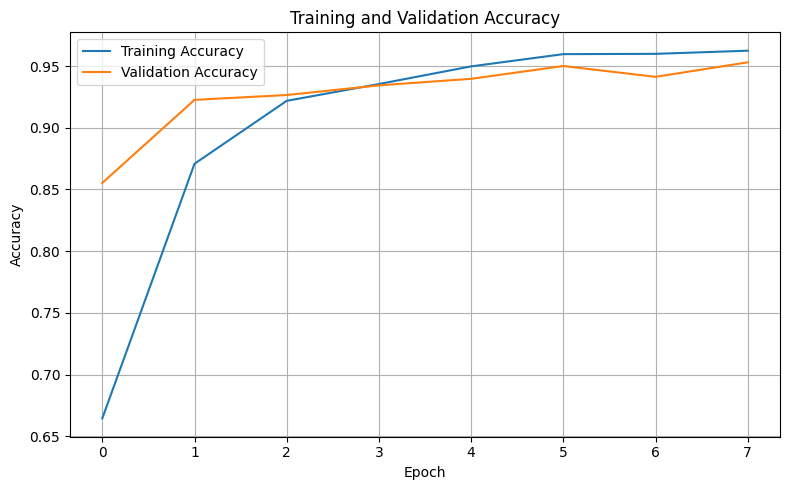

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:
from keras.models import Model
from keras.layers import Input

input_layer = Input(shape=(150,150,3))
x = model.layers[0](input_layer) # VGG-16 LAYER
x = model.layers[1](x)          # FLATTEN LAYER
embedding_output = model.layers[2](x)          # 256-DIM LAYER
# embedding_output = model.layers[3](x)  # 128-DIM LAYER

embedding_model = Model(inputs=input_layer, outputs=embedding_output)

In [66]:
from keras.preprocessing import image
import numpy as np

def get_embedding(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return embedding_model.predict(x)[0]

In [67]:
import os

train_dir = '/content/train'

dataset_image_paths = []

# Walking through each class folder and get all image paths
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path = os.path.join(root, file)
            dataset_image_paths.append(full_path)

print(f"Found {len(dataset_image_paths)} training images.")


Found 4335 training images.


In [69]:
datagen = ImageDataGenerator(rescale=1./255)

batch_size = 16

train_generator = datagen.flow_from_directory(
    '/content/train',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 4335 images belonging to 64 classes.


In [70]:
# Get embeddings for the entire dataset in batches
embeddings = embedding_model.predict(train_generator, verbose=1)

# Map embeddings to image file paths
image_paths = train_generator.filepaths  # Relative paths
image_paths = [os.path.join('/content/train', path) for path in image_paths]


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


271/271 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step


In [95]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

query_img_path = '/content/train/Kyberge_lentils1/103.jpg'
query_embedding = get_embedding(query_img_path)

similarities = cosine_similarity([query_embedding], embeddings)[0]
top5_indices = similarities.argsort()[-5:][::-1]
top5_paths = [dataset_image_paths[i] for i in top5_indices]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


# Image Search on 256-DIM Vectors

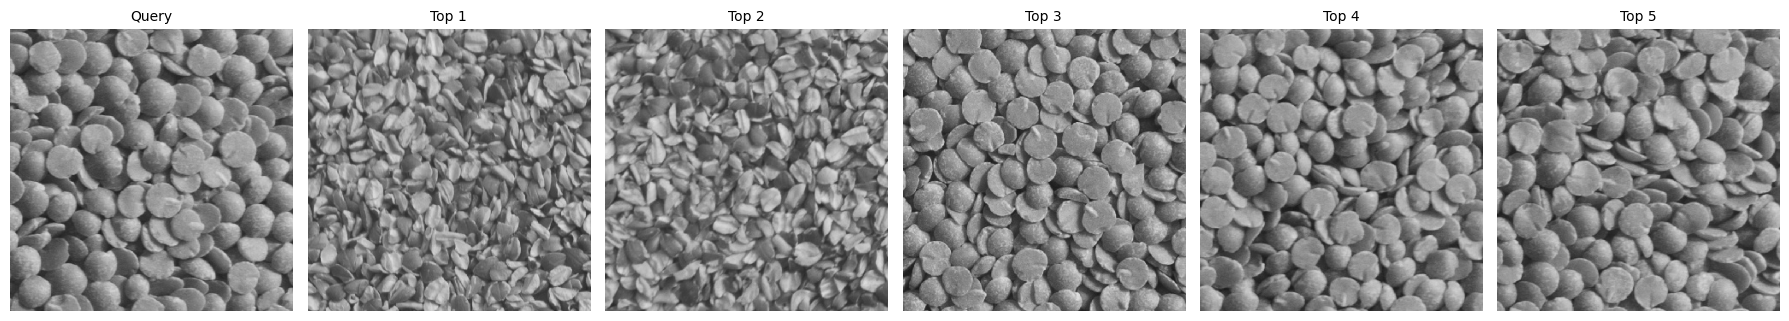

In [96]:
import matplotlib.pyplot as plt
from PIL import Image

all_paths = [query_img_path] + top5_paths
titles = ['Query'] + [f'Top {i+1}' for i in range(10)]

plt.figure(figsize=(18, 4))

for i, (path, title) in enumerate(zip(all_paths, titles)):
    img = Image.open(path)
    plt.subplot(1, 6, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=10)

plt.tight_layout()
plt.show()
